# **1. Installation and Setup of Required Libraries**

In [1]:
%%capture
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize the API
api = KaggleApi()
api.authenticate()

# Download the dataset
dataset = "pradeepjangirml007/laptop-data-set"
api.dataset_download_files(dataset, path="./data", unzip=True)

print("Dataset downloaded and extracted to ./data")

Dataset URL: https://www.kaggle.com/datasets/pradeepjangirml007/laptop-data-set
Dataset downloaded and extracted to ./data


In [5]:
!ls ./data

laptop.csv


In [6]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [7]:
df = pd.read_csv("./data/laptop.csv")
df.head()

,Unnamed: 0,Brand,Name,Price,Processor_Name,Processor_Brand,RAM_Expandable,RAM,RAM_TYPE,Ghz,Display_type,Display,GPU,GPU_Brand,SSD,HDD,Adapter,Battery_Life
0,0,HP,HP Chromebook 11A-NA0002MU (2E4N0PA) Laptop (1...,22990,MediaTek Octa-core,MediaTek,Not Expandable,4 GB,DDR4 RAM,2.0 Ghz Processor,LED,11.6,Integrated Graphics,MediaTek,64 GB SSD Storage,No HDD,45,Upto 12 Hrs Battery Life
1,1,Lenovo,Lenovo Ideapad Slim 3 (82KU017KIN) Laptop (15....,36289,AMD Hexa-Core Ryzen 5,AMD,12 GB Expandable,8 GB,DDR4 RAM,4.0 Ghz Processor,LCD,15.6,Radeon,AMD,512 GB SSD Storage,No HDD,65,Upto 11 Hrs Battery Life
2,3,Dell,Dell G15-5520 (D560822WIN9B) Laptop (15.6 Inch...,78500,Intel Core i5 (12th Gen),Intel,32 GB Expandable,16 GB,DDR5 RAM,3.3 Ghz Processor,LCD,15.6,"GeForce RTX 3050 GPU, 4 GB",NVIDIA,512 GB SSD Storage,No HDD,56,Upto 10 Hrs Battery Life
3,4,HP,HP 15s-fy5007TU (91R03PA) Laptop (15.6 Inch | ...,55490,Intel Core i5 (12th Gen),Intel,8 GB Expandable,8 GB,DDR4 RAM,4.2 Ghz Processor,LCD,15.6,Iris Xe,Intel,512 GB SSD Storage,No HDD,no,Upto 7.30 Hrs Battery Life
4,6,Infinix,Infinix Inbook Y2 Plus XL29 Laptop (15.6 Inch ...,21990,Intel Core i3 (11th Gen),Intel,Not Expandable,8 GB LP,LPDDR4X RAM,1.7 Ghz Processor,LCD,15.6,UHD,Intel,512 GB SSD Storage,No HDD,45,Upto 8 Hrs Battery Life


In [8]:
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3976 entries, 0 to 3975
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       3976 non-null   int64 
 1   Brand            3976 non-null   object
 2   Name             3976 non-null   object
 3   Price            3976 non-null   int64 
 4   Processor_Name   3976 non-null   object
 5   Processor_Brand  3976 non-null   object
 6   RAM_Expandable   3976 non-null   object
 7   RAM              3976 non-null   object
 8   RAM_TYPE         3976 non-null   object
 9   Ghz              3976 non-null   object
 10  Display_type     3976 non-null   object
 11  Display          3976 non-null   object
 12  GPU              3968 non-null   object
 13  GPU_Brand        3972 non-null   object
 14  SSD              3976 non-null   object
 15  HDD              3976 non-null   object
 16  Adapter          3976 non-null   object
 17  Battery_Life     3558 non-null   

# **2. Data Preprocessing**

In [9]:
df = df.drop(columns=['Unnamed: 0'])

In [10]:
# Remove all non-numeric characters (e.g., 'GB', 'LP', 'RAM', etc.)
df['RAM'] = df['RAM'].str.replace(r'[^0-9.]', '', regex=True)

# Convert the cleaned column to float
df['RAM'] = pd.to_numeric(df['RAM'], errors='coerce')

df.head()

,Brand,Name,Price,Processor_Name,Processor_Brand,RAM_Expandable,RAM,RAM_TYPE,Ghz,Display_type,Display,GPU,GPU_Brand,SSD,HDD,Adapter,Battery_Life
0,HP,HP Chromebook 11A-NA0002MU (2E4N0PA) Laptop (1...,22990,MediaTek Octa-core,MediaTek,Not Expandable,4,DDR4 RAM,2.0 Ghz Processor,LED,11.6,Integrated Graphics,MediaTek,64 GB SSD Storage,No HDD,45,Upto 12 Hrs Battery Life
1,Lenovo,Lenovo Ideapad Slim 3 (82KU017KIN) Laptop (15....,36289,AMD Hexa-Core Ryzen 5,AMD,12 GB Expandable,8,DDR4 RAM,4.0 Ghz Processor,LCD,15.6,Radeon,AMD,512 GB SSD Storage,No HDD,65,Upto 11 Hrs Battery Life
2,Dell,Dell G15-5520 (D560822WIN9B) Laptop (15.6 Inch...,78500,Intel Core i5 (12th Gen),Intel,32 GB Expandable,16,DDR5 RAM,3.3 Ghz Processor,LCD,15.6,"GeForce RTX 3050 GPU, 4 GB",NVIDIA,512 GB SSD Storage,No HDD,56,Upto 10 Hrs Battery Life
3,HP,HP 15s-fy5007TU (91R03PA) Laptop (15.6 Inch | ...,55490,Intel Core i5 (12th Gen),Intel,8 GB Expandable,8,DDR4 RAM,4.2 Ghz Processor,LCD,15.6,Iris Xe,Intel,512 GB SSD Storage,No HDD,no,Upto 7.30 Hrs Battery Life
4,Infinix,Infinix Inbook Y2 Plus XL29 Laptop (15.6 Inch ...,21990,Intel Core i3 (11th Gen),Intel,Not Expandable,8,LPDDR4X RAM,1.7 Ghz Processor,LCD,15.6,UHD,Intel,512 GB SSD Storage,No HDD,45,Upto 8 Hrs Battery Life


In [11]:
if 'RAM_Expandable' in df.columns:
    # Remove all non-numeric characters (e.g., 'GB', 'Expandable', etc.)
    df['RAM_Expandable'] = df['RAM_Expandable'].str.replace(r'[^0-9.]', '', regex=True)

    # Convert to float, setting invalid values to NaN
    df['RAM_Expandable'] = pd.to_numeric(df['RAM_Expandable'], errors='coerce')


df.head()

,Brand,Name,Price,Processor_Name,Processor_Brand,RAM_Expandable,RAM,RAM_TYPE,Ghz,Display_type,Display,GPU,GPU_Brand,SSD,HDD,Adapter,Battery_Life
0,HP,HP Chromebook 11A-NA0002MU (2E4N0PA) Laptop (1...,22990,MediaTek Octa-core,MediaTek,NaN,4,DDR4 RAM,2.0 Ghz Processor,LED,11.6,Integrated Graphics,MediaTek,64 GB SSD Storage,No HDD,45,Upto 12 Hrs Battery Life
1,Lenovo,Lenovo Ideapad Slim 3 (82KU017KIN) Laptop (15....,36289,AMD Hexa-Core Ryzen 5,AMD,12.0,8,DDR4 RAM,4.0 Ghz Processor,LCD,15.6,Radeon,AMD,512 GB SSD Storage,No HDD,65,Upto 11 Hrs Battery Life
2,Dell,Dell G15-5520 (D560822WIN9B) Laptop (15.6 Inch...,78500,Intel Core i5 (12th Gen),Intel,32.0,16,DDR5 RAM,3.3 Ghz Processor,LCD,15.6,"GeForce RTX 3050 GPU, 4 GB",NVIDIA,512 GB SSD Storage,No HDD,56,Upto 10 Hrs Battery Life
3,HP,HP 15s-fy5007TU (91R03PA) Laptop (15.6 Inch | ...,55490,Intel Core i5 (12th Gen),Intel,8.0,8,DDR4 RAM,4.2 Ghz Processor,LCD,15.6,Iris Xe,Intel,512 GB SSD Storage,No HDD,no,Upto 7.30 Hrs Battery Life
4,Infinix,Infinix Inbook Y2 Plus XL29 Laptop (15.6 Inch ...,21990,Intel Core i3 (11th Gen),Intel,NaN,8,LPDDR4X RAM,1.7 Ghz Processor,LCD,15.6,UHD,Intel,512 GB SSD Storage,No HDD,45,Upto 8 Hrs Battery Life


In [12]:
df['Processor_Gen'] = df['Processor_Name'].str.extract(r'(\d+)').astype(float)

df = df.drop(columns=['Processor_Name'])

df.head()

,Brand,Name,Price,Processor_Brand,RAM_Expandable,RAM,RAM_TYPE,Ghz,Display_type,Display,GPU,GPU_Brand,SSD,HDD,Adapter,Battery_Life,Processor_Gen
0,HP,HP Chromebook 11A-NA0002MU (2E4N0PA) Laptop (1...,22990,MediaTek,NaN,4,DDR4 RAM,2.0 Ghz Processor,LED,11.6,Integrated Graphics,MediaTek,64 GB SSD Storage,No HDD,45,Upto 12 Hrs Battery Life,NaN
1,Lenovo,Lenovo Ideapad Slim 3 (82KU017KIN) Laptop (15....,36289,AMD,12.0,8,DDR4 RAM,4.0 Ghz Processor,LCD,15.6,Radeon,AMD,512 GB SSD Storage,No HDD,65,Upto 11 Hrs Battery Life,5.0
2,Dell,Dell G15-5520 (D560822WIN9B) Laptop (15.6 Inch...,78500,Intel,32.0,16,DDR5 RAM,3.3 Ghz Processor,LCD,15.6,"GeForce RTX 3050 GPU, 4 GB",NVIDIA,512 GB SSD Storage,No HDD,56,Upto 10 Hrs Battery Life,5.0
3,HP,HP 15s-fy5007TU (91R03PA) Laptop (15.6 Inch | ...,55490,Intel,8.0,8,DDR4 RAM,4.2 Ghz Processor,LCD,15.6,Iris Xe,Intel,512 GB SSD Storage,No HDD,no,Upto 7.30 Hrs Battery Life,5.0
4,Infinix,Infinix Inbook Y2 Plus XL29 Laptop (15.6 Inch ...,21990,Intel,NaN,8,LPDDR4X RAM,1.7 Ghz Processor,LCD,15.6,UHD,Intel,512 GB SSD Storage,No HDD,45,Upto 8 Hrs Battery Life,3.0


In [13]:
df['Ghz'] = df['Ghz'].str.extract(r'(\d+\.?\d*)').astype(float)

df.head()

,Brand,Name,Price,Processor_Brand,RAM_Expandable,RAM,RAM_TYPE,Ghz,Display_type,Display,GPU,GPU_Brand,SSD,HDD,Adapter,Battery_Life,Processor_Gen
0,HP,HP Chromebook 11A-NA0002MU (2E4N0PA) Laptop (1...,22990,MediaTek,NaN,4,DDR4 RAM,2.0,LED,11.6,Integrated Graphics,MediaTek,64 GB SSD Storage,No HDD,45,Upto 12 Hrs Battery Life,NaN
1,Lenovo,Lenovo Ideapad Slim 3 (82KU017KIN) Laptop (15....,36289,AMD,12.0,8,DDR4 RAM,4.0,LCD,15.6,Radeon,AMD,512 GB SSD Storage,No HDD,65,Upto 11 Hrs Battery Life,5.0
2,Dell,Dell G15-5520 (D560822WIN9B) Laptop (15.6 Inch...,78500,Intel,32.0,16,DDR5 RAM,3.3,LCD,15.6,"GeForce RTX 3050 GPU, 4 GB",NVIDIA,512 GB SSD Storage,No HDD,56,Upto 10 Hrs Battery Life,5.0
3,HP,HP 15s-fy5007TU (91R03PA) Laptop (15.6 Inch | ...,55490,Intel,8.0,8,DDR4 RAM,4.2,LCD,15.6,Iris Xe,Intel,512 GB SSD Storage,No HDD,no,Upto 7.30 Hrs Battery Life,5.0
4,Infinix,Infinix Inbook Y2 Plus XL29 Laptop (15.6 Inch ...,21990,Intel,NaN,8,LPDDR4X RAM,1.7,LCD,15.6,UHD,Intel,512 GB SSD Storage,No HDD,45,Upto 8 Hrs Battery Life,3.0


In [14]:
df['SSD'] = df['SSD'].str.extract(r'(\d+\.?\d*)').astype(float)

df.head()

,Brand,Name,Price,Processor_Brand,RAM_Expandable,RAM,RAM_TYPE,Ghz,Display_type,Display,GPU,GPU_Brand,SSD,HDD,Adapter,Battery_Life,Processor_Gen
0,HP,HP Chromebook 11A-NA0002MU (2E4N0PA) Laptop (1...,22990,MediaTek,NaN,4,DDR4 RAM,2.0,LED,11.6,Integrated Graphics,MediaTek,64.0,No HDD,45,Upto 12 Hrs Battery Life,NaN
1,Lenovo,Lenovo Ideapad Slim 3 (82KU017KIN) Laptop (15....,36289,AMD,12.0,8,DDR4 RAM,4.0,LCD,15.6,Radeon,AMD,512.0,No HDD,65,Upto 11 Hrs Battery Life,5.0
2,Dell,Dell G15-5520 (D560822WIN9B) Laptop (15.6 Inch...,78500,Intel,32.0,16,DDR5 RAM,3.3,LCD,15.6,"GeForce RTX 3050 GPU, 4 GB",NVIDIA,512.0,No HDD,56,Upto 10 Hrs Battery Life,5.0
3,HP,HP 15s-fy5007TU (91R03PA) Laptop (15.6 Inch | ...,55490,Intel,8.0,8,DDR4 RAM,4.2,LCD,15.6,Iris Xe,Intel,512.0,No HDD,no,Upto 7.30 Hrs Battery Life,5.0
4,Infinix,Infinix Inbook Y2 Plus XL29 Laptop (15.6 Inch ...,21990,Intel,NaN,8,LPDDR4X RAM,1.7,LCD,15.6,UHD,Intel,512.0,No HDD,45,Upto 8 Hrs Battery Life,3.0


In [15]:
df['HDD'].unique()

array(['No HDD', '1024 GB HDD Storage', ' 1024 GB HDD Storage',
       '2048 GB HDD Storage', '500 GB HDD Storage',
       ' 2048 GB HDD Storage', ' 500 GB HDD Storage', '1 GB HDD Storage'],
      dtype=object)

In [16]:
def convert_to_gb(hdd_str):
    if pd.isna(hdd_str) or 'No HDD' in str(hdd_str):
        return 0
    size_unit = re.search(r'(\d+)\s*(GB|TB)', str(hdd_str))
    if size_unit:
        size, unit = float(size_unit.group(1)), size_unit.group(2)
        return size * 1024 if unit == 'TB' else size
    return 0  # Default if no match

# Apply the function and convert to integer
df['HDD'] = df['HDD'].apply(convert_to_gb).astype(int)

df.head()

,Brand,Name,Price,Processor_Brand,RAM_Expandable,RAM,RAM_TYPE,Ghz,Display_type,Display,GPU,GPU_Brand,SSD,HDD,Adapter,Battery_Life,Processor_Gen
0,HP,HP Chromebook 11A-NA0002MU (2E4N0PA) Laptop (1...,22990,MediaTek,NaN,4,DDR4 RAM,2.0,LED,11.6,Integrated Graphics,MediaTek,64.0,0,45,Upto 12 Hrs Battery Life,NaN
1,Lenovo,Lenovo Ideapad Slim 3 (82KU017KIN) Laptop (15....,36289,AMD,12.0,8,DDR4 RAM,4.0,LCD,15.6,Radeon,AMD,512.0,0,65,Upto 11 Hrs Battery Life,5.0
2,Dell,Dell G15-5520 (D560822WIN9B) Laptop (15.6 Inch...,78500,Intel,32.0,16,DDR5 RAM,3.3,LCD,15.6,"GeForce RTX 3050 GPU, 4 GB",NVIDIA,512.0,0,56,Upto 10 Hrs Battery Life,5.0
3,HP,HP 15s-fy5007TU (91R03PA) Laptop (15.6 Inch | ...,55490,Intel,8.0,8,DDR4 RAM,4.2,LCD,15.6,Iris Xe,Intel,512.0,0,no,Upto 7.30 Hrs Battery Life,5.0
4,Infinix,Infinix Inbook Y2 Plus XL29 Laptop (15.6 Inch ...,21990,Intel,NaN,8,LPDDR4X RAM,1.7,LCD,15.6,UHD,Intel,512.0,0,45,Upto 8 Hrs Battery Life,3.0


In [17]:
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3976 entries, 0 to 3975
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Brand            3976 non-null   object 
 1   Name             3976 non-null   object 
 2   Price            3976 non-null   int64  
 3   Processor_Brand  3976 non-null   object 
 4   RAM_Expandable   1819 non-null   float64
 5   RAM              3976 non-null   int64  
 6   RAM_TYPE         3976 non-null   object 
 7   Ghz              3976 non-null   float64
 8   Display_type     3976 non-null   object 
 9   Display          3976 non-null   object 
 10  GPU              3968 non-null   object 
 11  GPU_Brand        3972 non-null   object 
 12  SSD              3312 non-null   float64
 13  HDD              3976 non-null   int64  
 14  Adapter          3976 non-null   object 
 15  Battery_Life     3558 non-null   object 
 16  Processor_Gen    3739 non-null   float64
dtypes: float64(4),

In [18]:
df['RAM_Expandable'] = df['RAM_Expandable'].fillna(0)
df['SSD'] = df['SSD'].fillna(0)
df['Processor_Gen'] = df['Processor_Gen'].fillna(0)

In [19]:
df.dropna(subset=['GPU_Brand'], inplace=True)

In [20]:
df['Display'].unique()

array(['11.6 ', '15.6 ', '14 ', '16 ', '17.3 ', '13.3 ', '16.1 ', '13.6 ',
       '14.2 ', '14.1 ', '15.3 ', '13.4 ', '15 ', '10.5 ', '13.5 ', '13 ',
       '12.4 ', '16.2 ', 'OLED Display With Touchscreen', '14.0 ', '17 ',
       '18 ', '14.5 ', '12 ', '10.1 ', '15. ', '14.9 ', '11 ', '12.3 ',
       '16.6 ', '12.2 ', '12.5 ', '15.4 ', '12.0 '], dtype=object)

In [21]:
def clean_display_column(df, column_name='Display'):
    cleaned_df = df.copy()
    cleaned_df[column_name] = cleaned_df[column_name].str.strip()
    cleaned_df[column_name] = pd.to_numeric(cleaned_df[column_name], errors='coerce')
    cleaned_df = cleaned_df.dropna(subset=[column_name])
    cleaned_df[column_name] = cleaned_df[column_name].astype(float)
    return cleaned_df

df = clean_display_column(df, 'Display')

df.head()

,Brand,Name,Price,Processor_Brand,RAM_Expandable,RAM,RAM_TYPE,Ghz,Display_type,Display,GPU,GPU_Brand,SSD,HDD,Adapter,Battery_Life,Processor_Gen
0,HP,HP Chromebook 11A-NA0002MU (2E4N0PA) Laptop (1...,22990,MediaTek,0.0,4,DDR4 RAM,2.0,LED,11.6,Integrated Graphics,MediaTek,64.0,0,45,Upto 12 Hrs Battery Life,0.0
1,Lenovo,Lenovo Ideapad Slim 3 (82KU017KIN) Laptop (15....,36289,AMD,12.0,8,DDR4 RAM,4.0,LCD,15.6,Radeon,AMD,512.0,0,65,Upto 11 Hrs Battery Life,5.0
2,Dell,Dell G15-5520 (D560822WIN9B) Laptop (15.6 Inch...,78500,Intel,32.0,16,DDR5 RAM,3.3,LCD,15.6,"GeForce RTX 3050 GPU, 4 GB",NVIDIA,512.0,0,56,Upto 10 Hrs Battery Life,5.0
3,HP,HP 15s-fy5007TU (91R03PA) Laptop (15.6 Inch | ...,55490,Intel,8.0,8,DDR4 RAM,4.2,LCD,15.6,Iris Xe,Intel,512.0,0,no,Upto 7.30 Hrs Battery Life,5.0
4,Infinix,Infinix Inbook Y2 Plus XL29 Laptop (15.6 Inch ...,21990,Intel,0.0,8,LPDDR4X RAM,1.7,LCD,15.6,UHD,Intel,512.0,0,45,Upto 8 Hrs Battery Life,3.0


In [22]:
df['Adapter'].unique()

array(['45', '65', '56', 'no', '150', '170', '230', '135', '41', '100',
       '90', '120', '96', '180', '63', '30', '54', '33', '46', '67', '57',
       '43', '48', '70', '37', '24', '42', '330', '200', '58', '240',
       '50', '280', '60', '80', '35', '51', '61', '76', '38', '86', '66',
       '210', '39', '97', '140', '83', '59', '53', '71', '75', '74', '49',
       '300', '68', '52', '40', '36', '32', '15', '26', '47', '64', '130',
       '87', '72', '95', '69'], dtype=object)

In [23]:
def convert_adapter_to_int(df, column_name='Adapter'):

    df[column_name] = df[column_name].replace('no', '0')

    df[column_name] = df[column_name].apply(lambda x: pd.to_numeric(x, errors='ignore'))

    return df

df = convert_adapter_to_int(df, 'Adapter')

df.head()

<ipython-input-23-6ffeed507fba>:5: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[column_name] = df[column_name].apply(lambda x: pd.to_numeric(x, errors='ignore'))


,Brand,Name,Price,Processor_Brand,RAM_Expandable,RAM,RAM_TYPE,Ghz,Display_type,Display,GPU,GPU_Brand,SSD,HDD,Adapter,Battery_Life,Processor_Gen
0,HP,HP Chromebook 11A-NA0002MU (2E4N0PA) Laptop (1...,22990,MediaTek,0.0,4,DDR4 RAM,2.0,LED,11.6,Integrated Graphics,MediaTek,64.0,0,45,Upto 12 Hrs Battery Life,0.0
1,Lenovo,Lenovo Ideapad Slim 3 (82KU017KIN) Laptop (15....,36289,AMD,12.0,8,DDR4 RAM,4.0,LCD,15.6,Radeon,AMD,512.0,0,65,Upto 11 Hrs Battery Life,5.0
2,Dell,Dell G15-5520 (D560822WIN9B) Laptop (15.6 Inch...,78500,Intel,32.0,16,DDR5 RAM,3.3,LCD,15.6,"GeForce RTX 3050 GPU, 4 GB",NVIDIA,512.0,0,56,Upto 10 Hrs Battery Life,5.0
3,HP,HP 15s-fy5007TU (91R03PA) Laptop (15.6 Inch | ...,55490,Intel,8.0,8,DDR4 RAM,4.2,LCD,15.6,Iris Xe,Intel,512.0,0,0,Upto 7.30 Hrs Battery Life,5.0
4,Infinix,Infinix Inbook Y2 Plus XL29 Laptop (15.6 Inch ...,21990,Intel,0.0,8,LPDDR4X RAM,1.7,LCD,15.6,UHD,Intel,512.0,0,45,Upto 8 Hrs Battery Life,3.0


In [24]:
df['Processor_Brand'].unique()

array(['MediaTek', 'AMD', 'Intel', 'Apple', '2.3', '3.4', 'Qualcomm',
       '3.3', '1.6', '2.4', '3.0', '2.2', '1.7', '2.1', '2.0', '1.8',
       'Microsoft', '1.9', '2.6'], dtype=object)

In [25]:
def clean_processor_brand_auto(df, column_name='Processor_Brand'):
    cleaned_df = df.copy()

    cleaned_df[column_name] = cleaned_df[column_name].apply(
        lambda x: x if x.isalpha() else np.nan
    )

    cleaned_df = cleaned_df.dropna(subset=[column_name])
    return cleaned_df

df = clean_processor_brand_auto(df, 'Processor_Brand')

df.head()

,Brand,Name,Price,Processor_Brand,RAM_Expandable,RAM,RAM_TYPE,Ghz,Display_type,Display,GPU,GPU_Brand,SSD,HDD,Adapter,Battery_Life,Processor_Gen
0,HP,HP Chromebook 11A-NA0002MU (2E4N0PA) Laptop (1...,22990,MediaTek,0.0,4,DDR4 RAM,2.0,LED,11.6,Integrated Graphics,MediaTek,64.0,0,45,Upto 12 Hrs Battery Life,0.0
1,Lenovo,Lenovo Ideapad Slim 3 (82KU017KIN) Laptop (15....,36289,AMD,12.0,8,DDR4 RAM,4.0,LCD,15.6,Radeon,AMD,512.0,0,65,Upto 11 Hrs Battery Life,5.0
2,Dell,Dell G15-5520 (D560822WIN9B) Laptop (15.6 Inch...,78500,Intel,32.0,16,DDR5 RAM,3.3,LCD,15.6,"GeForce RTX 3050 GPU, 4 GB",NVIDIA,512.0,0,56,Upto 10 Hrs Battery Life,5.0
3,HP,HP 15s-fy5007TU (91R03PA) Laptop (15.6 Inch | ...,55490,Intel,8.0,8,DDR4 RAM,4.2,LCD,15.6,Iris Xe,Intel,512.0,0,0,Upto 7.30 Hrs Battery Life,5.0
4,Infinix,Infinix Inbook Y2 Plus XL29 Laptop (15.6 Inch ...,21990,Intel,0.0,8,LPDDR4X RAM,1.7,LCD,15.6,UHD,Intel,512.0,0,45,Upto 8 Hrs Battery Life,3.0


In [26]:
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 3951 entries, 0 to 3975
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Brand            3951 non-null   object 
 1   Name             3951 non-null   object 
 2   Price            3951 non-null   int64  
 3   Processor_Brand  3951 non-null   object 
 4   RAM_Expandable   3951 non-null   float64
 5   RAM              3951 non-null   int64  
 6   RAM_TYPE         3951 non-null   object 
 7   Ghz              3951 non-null   float64
 8   Display_type     3951 non-null   object 
 9   Display          3951 non-null   float64
 10  GPU              3943 non-null   object 
 11  GPU_Brand        3951 non-null   object 
 12  SSD              3951 non-null   float64
 13  HDD              3951 non-null   int64  
 14  Adapter          3951 non-null   int64  
 15  Battery_Life     3534 non-null   object 
 16  Processor_Gen    3951 non-null   float64
dtypes: float64(5), int6

In [27]:
df = df.drop(columns=['Name', 'GPU', 'Battery_Life'])

df.head()

,Brand,Price,Processor_Brand,RAM_Expandable,RAM,RAM_TYPE,Ghz,Display_type,Display,GPU_Brand,SSD,HDD,Adapter,Processor_Gen
0,HP,22990,MediaTek,0.0,4,DDR4 RAM,2.0,LED,11.6,MediaTek,64.0,0,45,0.0
1,Lenovo,36289,AMD,12.0,8,DDR4 RAM,4.0,LCD,15.6,AMD,512.0,0,65,5.0
2,Dell,78500,Intel,32.0,16,DDR5 RAM,3.3,LCD,15.6,NVIDIA,512.0,0,56,5.0
3,HP,55490,Intel,8.0,8,DDR4 RAM,4.2,LCD,15.6,Intel,512.0,0,0,5.0
4,Infinix,21990,Intel,0.0,8,LPDDR4X RAM,1.7,LCD,15.6,Intel,512.0,0,45,3.0


# **3. Displaying Processed Data**

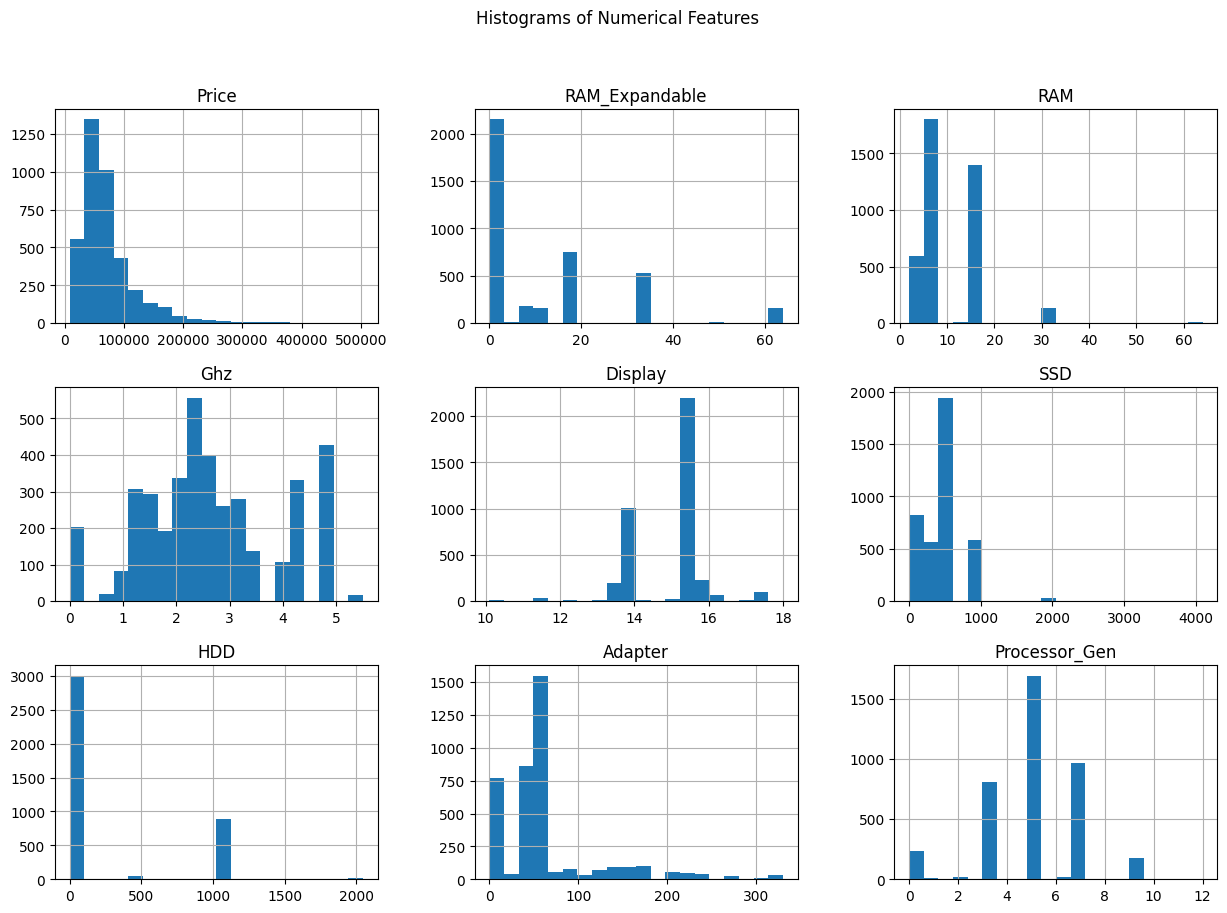

In [28]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numerical_cols].hist(bins=20, figsize=(15, 10))
plt.suptitle("Histograms of Numerical Features")
plt.show()

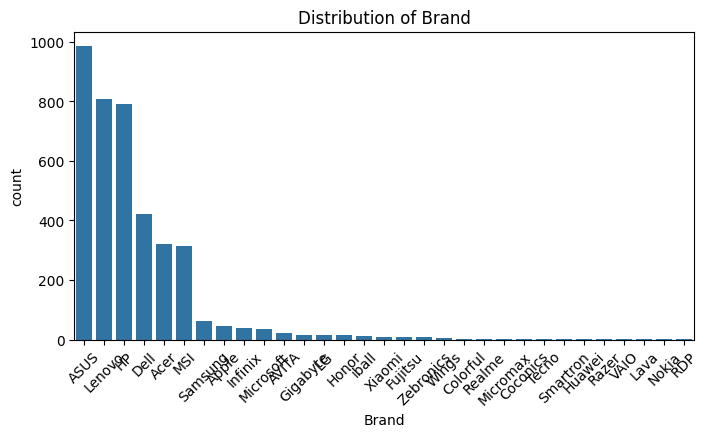

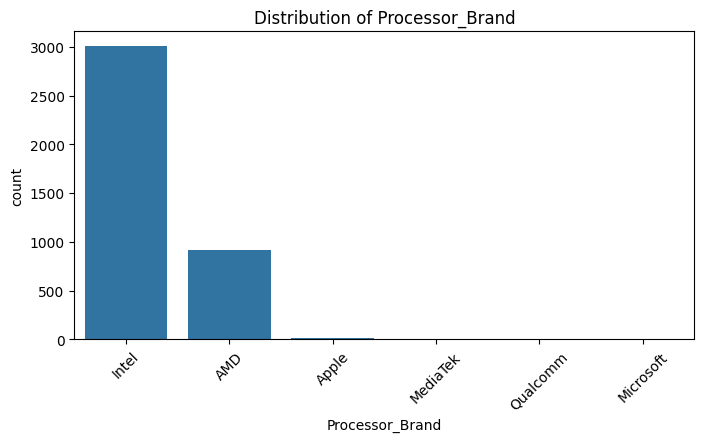

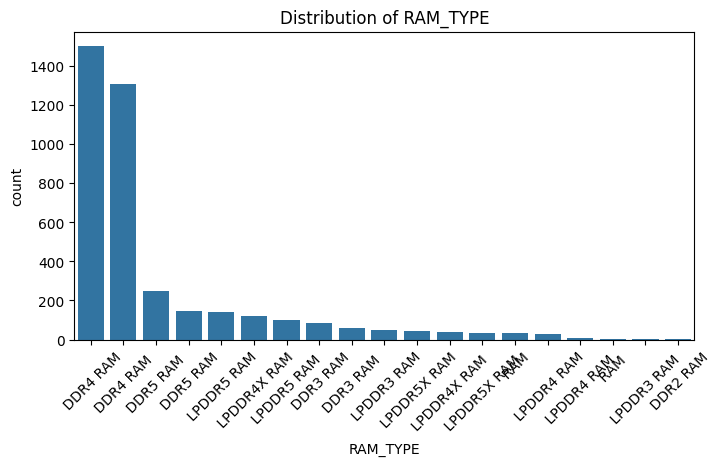

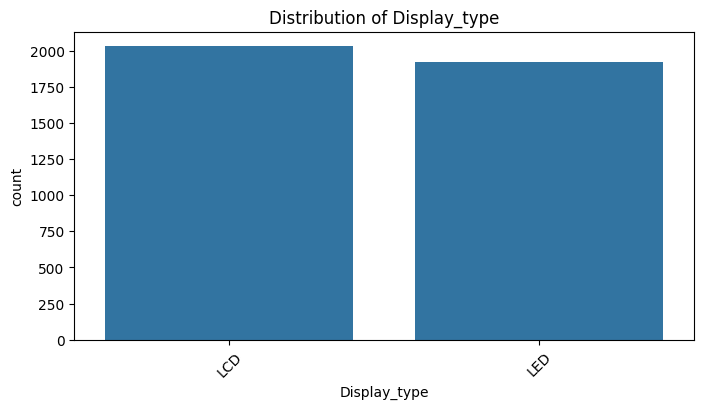

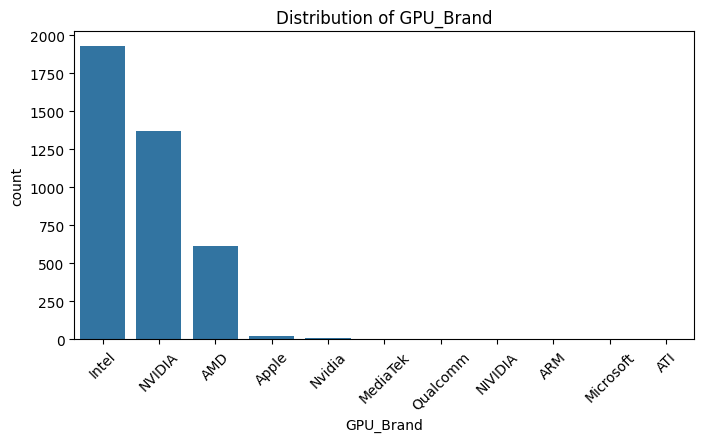

In [29]:
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

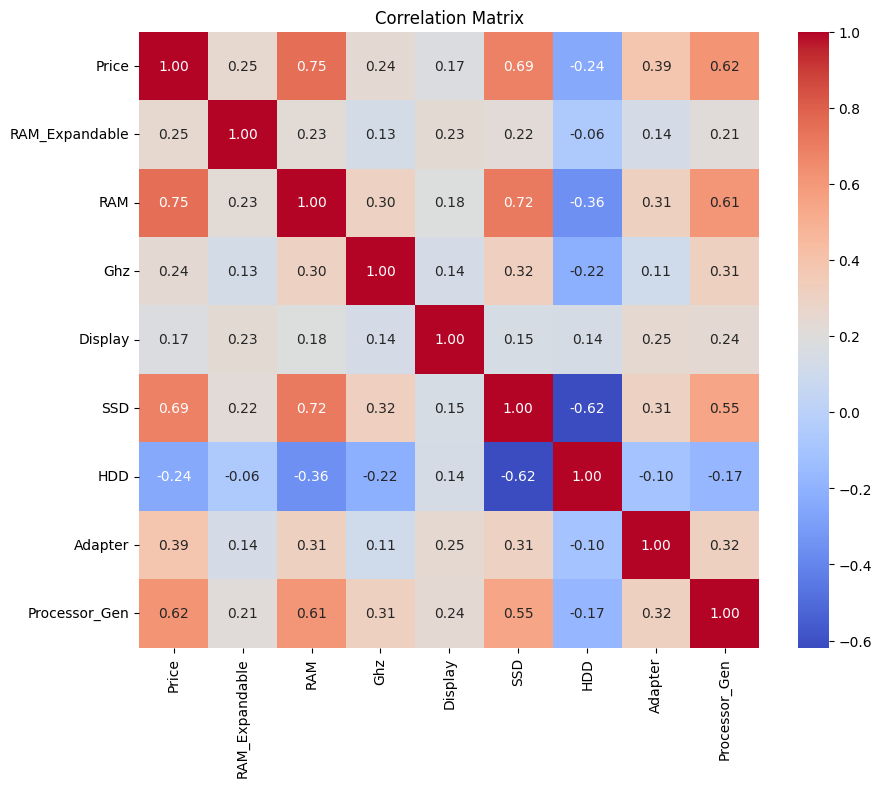

Price             1.000000
RAM               0.752626
SSD               0.689518
Processor_Gen     0.619659
Adapter           0.386511
RAM_Expandable    0.253461
Ghz               0.238917
Display           0.171801
HDD              -0.242523
Name: Price, dtype: float64


In [30]:
# Correlation matrix
corr_matrix = df[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

# Correlation with Price
print(corr_matrix['Price'].sort_values(ascending=False))

In [31]:
df.head()

,Brand,Price,Processor_Brand,RAM_Expandable,RAM,RAM_TYPE,Ghz,Display_type,Display,GPU_Brand,SSD,HDD,Adapter,Processor_Gen
0,HP,22990,MediaTek,0.0,4,DDR4 RAM,2.0,LED,11.6,MediaTek,64.0,0,45,0.0
1,Lenovo,36289,AMD,12.0,8,DDR4 RAM,4.0,LCD,15.6,AMD,512.0,0,65,5.0
2,Dell,78500,Intel,32.0,16,DDR5 RAM,3.3,LCD,15.6,NVIDIA,512.0,0,56,5.0
3,HP,55490,Intel,8.0,8,DDR4 RAM,4.2,LCD,15.6,Intel,512.0,0,0,5.0
4,Infinix,21990,Intel,0.0,8,LPDDR4X RAM,1.7,LCD,15.6,Intel,512.0,0,45,3.0


# **4. ML Models**

In [32]:
encoder = LabelEncoder()
df['Brand'] = encoder.fit_transform(df['Brand'])
df['Processor_Brand'] = encoder.fit_transform(df['Processor_Brand'])
df['RAM_TYPE'] = encoder.fit_transform(df['RAM_TYPE'])
df['Display_type'] = encoder.fit_transform(df['Display_type'])
df['GPU_Brand'] = encoder.fit_transform(df['GPU_Brand'])

In [33]:
df.head()

,Brand,Price,Processor_Brand,RAM_Expandable,RAM,RAM_TYPE,Ghz,Display_type,Display,GPU_Brand,SSD,HDD,Adapter,Processor_Gen
0,9,22990,3,0.0,4,3,2.0,1,11.6,5,64.0,0,45,0.0
1,15,36289,0,12.0,8,4,4.0,0,15.6,0,512.0,0,65,5.0
2,6,78500,2,32.0,16,6,3.3,0,15.6,8,512.0,0,56,5.0
3,9,55490,2,8.0,8,4,4.2,0,15.6,4,512.0,0,0,5.0
4,12,21990,2,0.0,8,11,1.7,0,15.6,4,512.0,0,45,3.0


In [34]:
X = df.drop(columns=['Price'])
y = df['Price']

In [35]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

In [38]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R²': r2}
    print(f'{name}:')
    print(f'  MSE: {mse}')
    print(f'  R²: {r2}')
    print('-' * 30)


best_model_name = max(results, key=lambda x: results[x]['R²'])
best_model = models[best_model_name]
print(f'Best Model: {best_model_name} with R²: {results[best_model_name]["R²"]}')

Linear Regression:
  MSE: 821552939.0084108
  R²: 0.6655843675601808
------------------------------
Decision Tree:
  MSE: 828699121.4194586
  R²: 0.6626754921888562
------------------------------
Random Forest:
  MSE: 550445984.5644093
  R²: 0.7759392811931973
------------------------------
XGBoost:
  MSE: 560742464.0
  R²: 0.7717480659484863
------------------------------
Neural Network:
  MSE: 684815627.208611
  R²: 0.7212437078564276
------------------------------
Best Model: Random Forest with R²: 0.7759392811931973


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


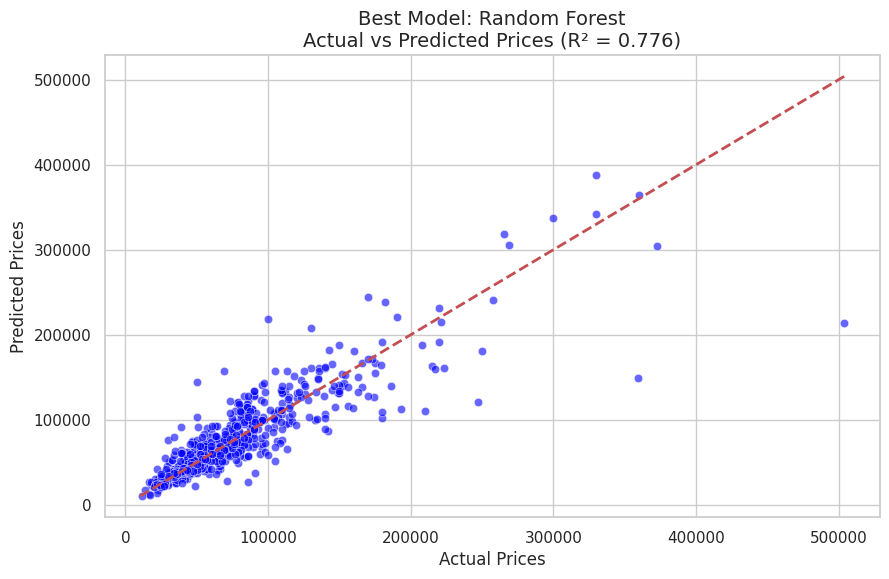

In [39]:
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.6, color='blue')

max_val = max(y_test.max(), y_pred_best.max())
min_val = min(y_test.min(), y_pred_best.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

r2 = r2_score(y_test, y_pred_best)

plt.title(f'Best Model: {best_model_name}\nActual vs Predicted Prices (R² = {r2:.3f})', fontsize=14)
plt.xlabel('Actual Prices', fontsize=12)
plt.ylabel('Predicted Prices', fontsize=12)
plt.grid(True)

plt.show()

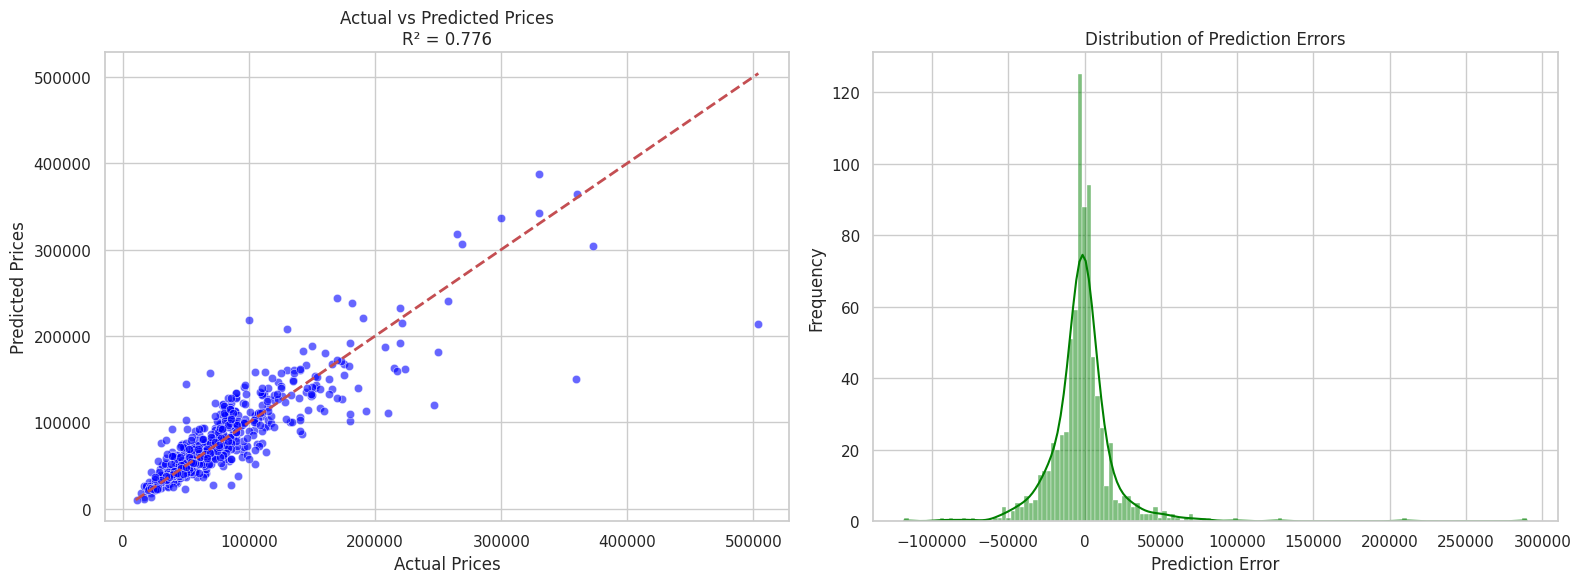

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.6, color='blue', ax=ax1)
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
ax1.set_title(f'Actual vs Predicted Prices\nR² = {r2:.3f}')
ax1.set_xlabel('Actual Prices')
ax1.set_ylabel('Predicted Prices')

errors = y_test - y_pred_best
sns.histplot(errors, kde=True, color='green', ax=ax2)
ax2.set_title('Distribution of Prediction Errors')
ax2.set_xlabel('Prediction Error')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [41]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [42]:
joblib.dump(best_model, 'laptop_price_predictor.pkl')

['laptop_price_predictor.pkl']